# Scratchpad
- last update: 24 Dec 2024

In [1]:
from sympy import *
import numpy as np
from scipy import signal
import scipy.fft
from scipy.signal import blackman
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()



## Voltage gain sweep
Use pandas and read LTSpice csv file


freq is 1kHz (could also explore 500Hz and 1200Hz)

.tran 0 5m 0

.step param V1_amp list 0.1 0.25 0.5 0.75 1

.step param Rgain list 1 25k 50k 75k 99.9k

.param Rtone=5k
.param Routput=99.999k


## Add more points
```
.step param Rgain list 1 250 500 750 1k 2.5k 5k 7.5k 10k 15k 20k 25k 30k 35k 40k 45k 50k 55k 60k 65k 70k 75k 80k 85k 90k 92.5k 95k 97.5k 99.9k

.step param V1_amp list 0.1 0.25 0.5 0.75 1.0 1.25 1.5

.param Rtone=5k
.param Routput=99.999k
```

In [2]:
LTSpice_data_fn = 'Sweep_Vin_&_Rgain.csv'

Could read data into pandas and then extract needed info

| Node | Connection |
|---|---|
| V(7) | U1A output |
| V(14) | U1B output |
| V(17) | right side of C10 |
| V(19) | U2A output |
| V(21) | U2B output |

In [3]:
LTSpice_sweep_df = pd.read_csv(LTSpice_data_fn)

In [4]:
LTSpice_sweep_df.head(10)

,time,V(7),V(14),V(17),V(19),V(21)
0,Step Information: V1_amp=100m Rgain=1 (Step: ...,NaN,NaN,NaN,NaN,NaN
1,0,4.499977,4.500065,4.500011,4.50035,4.499677
2,1.25000001460762E-08,4.499977,4.500065,4.500011,4.50035,4.499677
3,2.50000002921524E-08,4.499977,4.500065,4.500011,4.50035,4.499677
4,5.00000005843049E-08,4.499977,4.500065,4.500011,4.50035,4.499677
5,1.0000000116861E-07,4.499977,4.500065,4.500011,4.50035,4.499677
6,1.64014748699569E-07,4.499979,4.500065,4.500011,4.50035,4.499677
7,2.32493866672921E-07,4.499982,4.500066,4.500012,4.50035,4.499677
8,3.06618095803755E-07,4.499989,4.500068,4.500013,4.50035,4.499677
9,3.93268006393183E-07,4.500002,4.500070,4.500015,4.50035,4.499677


Find start of each new step.

In [5]:
lst = LTSpice_sweep_df['time'].tolist()

step_index = []
row_cnt = 0
for i in lst:
    if 'Step' in i:
        step_index.append(row_cnt)
    row_cnt += 1

In [6]:
step_index

In [7]:
len(step_index)

Use the following code and build a new dataframe, sweep_df. Rename df to LTSpice_sweep_df

In [8]:
sweep_df = pd.DataFrame(columns=['V1amp','Rgain','V7pp','V14pp','V17pp','V19pp','V21pp'])

In [9]:
for i in range(0,len(step_index)):
    #
    row_elements = LTSpice_sweep_df['time'][step_index[i]].split()

    #
    Rgain_str = row_elements[3][6:]
    Rgain_value = float(Rgain_str.replace('K', 'e3'))
    Rgain_percent = Rgain_value/100e3*100
    V1_amp_str = row_elements[2][7:]
    V1_amp_value = float(V1_amp_str.replace('m', 'e-3'))

    #
    if i == 0:
        v7_pp_value = LTSpice_sweep_df['V(7)'][0:step_index[i+1]].max() - LTSpice_sweep_df['V(7)'][0:step_index[i+1]].min()
        v14_pp_value = LTSpice_sweep_df['V(14)'][0:step_index[i+1]].max() - LTSpice_sweep_df['V(14)'][0:step_index[i+1]].min()
        v17_pp_value = LTSpice_sweep_df['V(17)'][0:step_index[i+1]].max() - LTSpice_sweep_df['V(17)'][0:step_index[i+1]].min()
        v19_pp_value = LTSpice_sweep_df['V(19)'][0:step_index[i+1]].max() - LTSpice_sweep_df['V(19)'][0:step_index[i+1]].min()
        v21_pp_value = LTSpice_sweep_df['V(21)'][0:step_index[i+1]].max() - LTSpice_sweep_df['V(21)'][0:step_index[i+1]].min()
    elif i < len(step_index)-1:
        v7_pp_value = LTSpice_sweep_df['V(7)'][step_index[i]:step_index[i+1]].max() - LTSpice_sweep_df['V(7)'][step_index[i]:step_index[i+1]].min()
        v14_pp_value = LTSpice_sweep_df['V(14)'][step_index[i]:step_index[i+1]].max() - LTSpice_sweep_df['V(14)'][step_index[i]:step_index[i+1]].min()
        v17_pp_value = LTSpice_sweep_df['V(17)'][step_index[i]:step_index[i+1]].max() - LTSpice_sweep_df['V(17)'][step_index[i]:step_index[i+1]].min()
        v19_pp_value = LTSpice_sweep_df['V(19)'][step_index[i]:step_index[i+1]].max() - LTSpice_sweep_df['V(19)'][step_index[i]:step_index[i+1]].min()        
        v21_pp_value = LTSpice_sweep_df['V(21)'][step_index[i]:step_index[i+1]].max() - LTSpice_sweep_df['V(21)'][step_index[i]:step_index[i+1]].min()        
    else:
        v7_pp_value = LTSpice_sweep_df['V(7)'][step_index[i]:-1].max() - LTSpice_sweep_df['V(7)'][step_index[i]:-1].min()        
        v14_pp_value = LTSpice_sweep_df['V(14)'][step_index[i]:-1].max() - LTSpice_sweep_df['V(14)'][step_index[i]:-1].min()  
        v17_pp_value = LTSpice_sweep_df['V(17)'][step_index[i]:-1].max() - LTSpice_sweep_df['V(17)'][step_index[i]:-1].min()  
        v19_pp_value = LTSpice_sweep_df['V(19)'][step_index[i]:-1].max() - LTSpice_sweep_df['V(19)'][step_index[i]:-1].min()   
        v21_pp_value = LTSpice_sweep_df['V(21)'][step_index[i]:-1].max() - LTSpice_sweep_df['V(21)'][step_index[i]:-1].min()          

    # load values into new dataframe
    sweep_df.loc[i] = [V1_amp_value, Rgain_percent, v7_pp_value,v14_pp_value,v17_pp_value,v19_pp_value,v21_pp_value]

In [10]:
sweep_df

,V1amp,Rgain,V7pp,V14pp,V17pp,V19pp,V21pp
0,0.10,0.001,0.197555,0.000146,0.000140,0.138082,0.161292
1,0.25,0.001,0.493868,0.000367,0.000352,0.345193,0.403173
2,0.50,0.001,0.987762,0.000732,0.000703,0.690350,0.806184
3,0.75,0.001,1.481557,0.001101,0.001054,1.035477,1.209899
4,1.00,0.001,1.975554,0.001466,0.001405,1.380598,1.612327
...,...,...,...,...,...,...,...
198,0.50,99.900,0.987655,5.914718,0.697959,7.617925,8.962181
199,0.75,99.900,1.481376,5.934829,0.699314,9.796335,11.582469
200,1.00,99.900,1.975297,5.946614,0.700103,11.996315,14.218597
201,1.25,99.900,2.469256,5.952623,0.700634,14.191300,16.860886


In [11]:
V1_amp_list = sweep_df['V1amp'].unique()
V1_amp_list

array([0.1 , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 ])

In [12]:
Rgain_list = sweep_df['Rgain'].unique()

In [13]:
for i in Rgain_list:
    print('{:.3f}'.format(i))

0.001
0.250
0.500
0.750
1.000
2.500
5.000
7.500
10.000
15.000
20.000
25.000
30.000
35.000
40.000
45.000
50.000
55.000
60.000
65.000
70.000
75.000
80.000
85.000
90.000
92.500
95.000
97.500
99.900


## 'V(7)'
Node V7 is the output of U1A. 

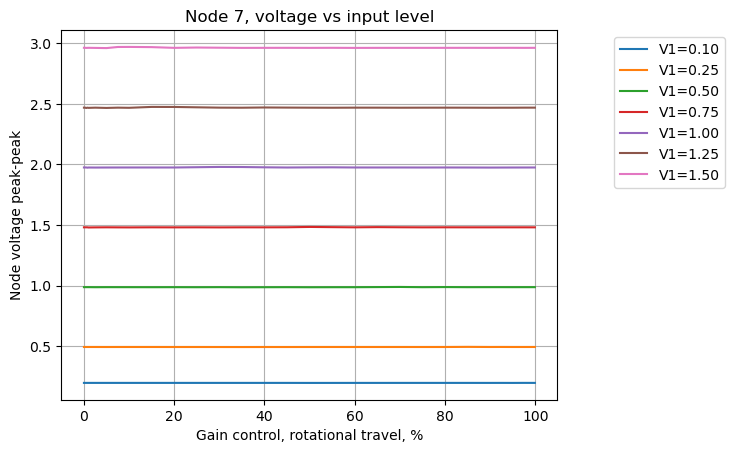

In [14]:
#| label: fig-Node_7_voltage_pp
#| echo: true
#| fig-cap: Node 7, voltage vs input level

for i in V1_amp_list:
    plt.plot(sweep_df[sweep_df['V1amp'] == i]['Rgain'].to_numpy(),sweep_df[sweep_df['V1amp'] == i]['V7pp'].to_numpy(),'-',label = 'V1={:.2f}'.format(i))

plt.ylabel('Node voltage peak-peak')
plt.xlabel('Gain control, rotational travel, %')
plt.grid()
plt.title('Node 7, voltage vs input level')

#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.1,1))
plt.show()

## 'V(14)'
Node V14 is the output of U1B. This is the distortion path part A. As can been seen, an input of 1.5 volts is needed to saturate the Op Amp at the lowest gain setting. At a gain setting of 50%, an  inout of 0.75 volts peak will drive the Op Amp into saturation. 

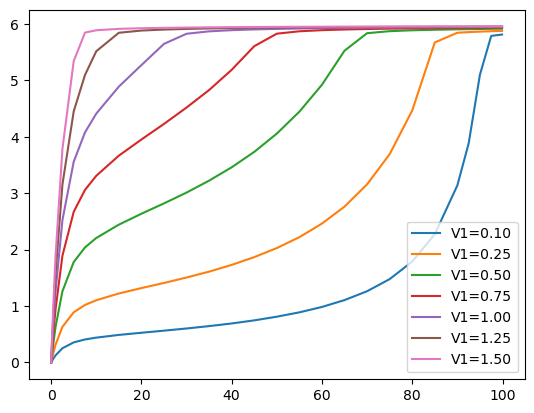

In [15]:
for i in V1_amp_list:
    plt.plot(sweep_df[sweep_df['V1amp'] == i]['Rgain'].to_numpy(),sweep_df[sweep_df['V1amp'] == i]['V14pp'].to_numpy(),'-',label = 'V1={:.2f}'.format(i))

plt.legend(loc="lower right")
plt.show()

## 'V(17)'
Node V17 is on the right side of C10, just past the diodes. Any in put level above 0.1 volts peak and gain settings over about 10% will drive the diodes into clipping. 


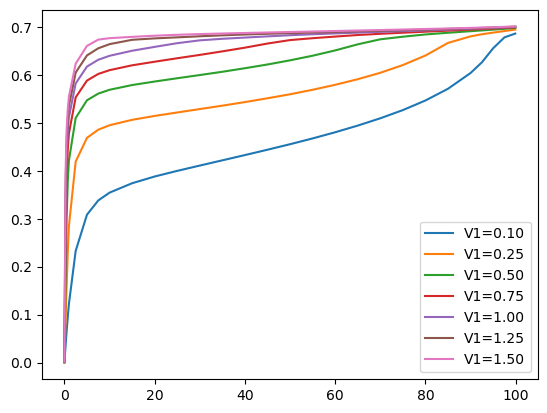

In [16]:
for i in V1_amp_list:
    plt.plot(sweep_df[sweep_df['V1amp'] == i]['Rgain'].to_numpy(),sweep_df[sweep_df['V1amp'] == i]['V17pp'].to_numpy(),'-',label = 'V1={:.2f}'.format(i))

plt.legend(loc="lower right")
plt.show()

## V(19)
Node 19 is output of U2A, the summing amp.

At gains greater than about 10 to 80, the voltage on node 19 is somewhat independednt of gain setting (mostly horizontal curve). 



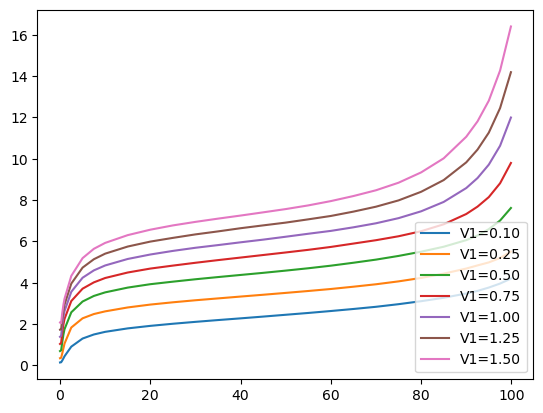

In [17]:
for i in V1_amp_list:
    plt.plot(sweep_df[sweep_df['V1amp'] == i]['Rgain'].to_numpy(),sweep_df[sweep_df['V1amp'] == i]['V19pp'].to_numpy(),'-',label = 'V1={:.2f}'.format(i))

plt.legend(loc="lower right")
plt.show()

## V(21)
Node 21 is the output of U2B. 

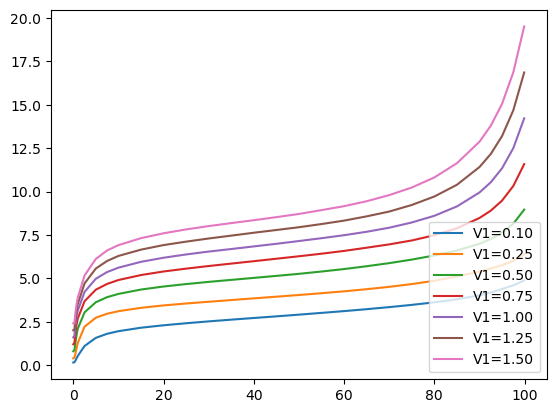

In [18]:
for i in V1_amp_list:
    plt.plot(sweep_df[sweep_df['V1amp'] == i]['Rgain'].to_numpy(),sweep_df[sweep_df['V1amp'] == i]['V21pp'].to_numpy(),'-',label = 'V1={:.2f}'.format(i))

plt.legend(loc="lower right")
plt.show()

## build dataframe of time domain data

In [19]:
step_index

In [20]:
td_node_voltage_df = pd.DataFrame(columns=['V1amp','Rgain','time','V7','V14','V17','V19','V21'])

In [21]:
for i in range(0,len(step_index)):
    #
    row_elements = LTSpice_sweep_df['time'][step_index[i]].split()

    #
    Rgain_str = row_elements[3][6:]
    Rgain_value = float(Rgain_str.replace('K', 'e3'))
    Rgain_percent = Rgain_value/100e3*100
    V1_amp_str = row_elements[2][7:]
    V1_amp_value = float(V1_amp_str.replace('m', 'e-3'))

    #
    if i == 0:
        time_values = LTSpice_sweep_df['time'][1:step_index[i+1]].to_numpy()
        v7_values = LTSpice_sweep_df['V(7)'][1:step_index[i+1]].to_numpy()
        v14_values = LTSpice_sweep_df['V(14)'][1:step_index[i+1]].to_numpy()
        v17_values = LTSpice_sweep_df['V(17)'][1:step_index[i+1]].to_numpy()
        v19_values = LTSpice_sweep_df['V(19)'][1:step_index[i+1]].to_numpy()
        v21_values = LTSpice_sweep_df['V(21)'][1:step_index[i+1]].to_numpy()
    elif (i != 0) and (i < len(step_index)-1):
        time_values = LTSpice_sweep_df['time'][step_index[i]+1:step_index[i+1]].to_numpy()
        v7_values = LTSpice_sweep_df['V(7)'][step_index[i]+1:step_index[i+1]].to_numpy()
        v14_values = LTSpice_sweep_df['V(14)'][step_index[i]+1:step_index[i+1]].to_numpy()
        v17_values = LTSpice_sweep_df['V(17)'][step_index[i]+1:step_index[i+1]].to_numpy()
        v19_values = LTSpice_sweep_df['V(19)'][step_index[i]+1:step_index[i+1]].to_numpy()
        v21_values = LTSpice_sweep_df['V(21)'][step_index[i]+1:step_index[i+1]].to_numpy()
    else:
        time_values = LTSpice_sweep_df['time'][step_index[i]+1:-1].to_numpy()
        v7_values = LTSpice_sweep_df['V(7)'][step_index[i]+1:-1].to_numpy()
        v14_values = LTSpice_sweep_df['V(14)'][step_index[i]+1:-1].to_numpy()
        v17_values = LTSpice_sweep_df['V(17)'][step_index[i]+1:-1].to_numpy()
        v19_values = LTSpice_sweep_df['V(19)'][step_index[i]+1:-1].to_numpy()
        v21_values = LTSpice_sweep_df['V(21)'][step_index[i]+1:-1].to_numpy()

    # load values into new dataframe
    td_node_voltage_df.loc[i] = [V1_amp_value, Rgain_percent,time_values,v7_values,v14_values,v17_values,v19_values,v21_values]

Time values are string with dtype = obj

In [22]:
time_values

array(['0', '6.25000007303811E-09', '1.25000001460762E-08', ...,
       '0.0199606241015302', '0.0199781060060535', '0.0199954077337411'],
      dtype=object)

In [23]:
td_node_voltage_df.head(10)

,V1amp,Rgain,time,V7,V14,V17,V19,V21
0,0.10,0.001,"[0, 1.25000001460762E-08, 2.50000002921524E-08...","[4.499977, 4.499977, 4.499977, 4.499977, 4.499...","[4.500065, 4.500065, 4.500065, 4.500065, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.50035, 4.50035, 4.50035, 4.50035, 4.50035, ...","[4.499677, 4.499677, 4.499677, 4.499677, 4.499..."
1,0.25,0.001,"[0, 6.25000007303811E-09, 1.25000001460762E-08...","[4.499977, 4.499977, 4.499977, 4.499977, 4.499...","[4.500065, 4.500065, 4.500065, 4.500065, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.50035, 4.50035, 4.50035, 4.50035, 4.50035, ...","[4.499677, 4.499677, 4.499677, 4.499677, 4.499..."
2,0.50,0.001,"[0, 6.25000007303811E-09, 1.25000001460762E-08...","[4.499977, 4.499977, 4.499977, 4.499977, 4.499...","[4.500065, 4.500065, 4.500065, 4.500065, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.50035, 4.50035, 4.50035, 4.50035, 4.50035, ...","[4.499677, 4.499677, 4.499677, 4.499677, 4.499..."
3,0.75,0.001,"[0, 6.25000007303811E-09, 1.25000001460762E-08...","[4.499977, 4.499977, 4.499977, 4.499977, 4.499...","[4.500065, 4.500065, 4.500065, 4.500065, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.50035, 4.50035, 4.50035, 4.50035, 4.50035, ...","[4.499677, 4.499677, 4.499677, 4.499677, 4.499..."
4,1.00,0.001,"[0, 6.25000007303811E-09, 1.25000001460762E-08...","[4.499977, 4.499977, 4.499977, 4.499977, 4.499...","[4.500065, 4.500065, 4.500065, 4.500065, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.50035, 4.50035, 4.50035, 4.50035, 4.50035, ...","[4.499677, 4.499677, 4.499677, 4.499677, 4.499..."
5,1.25,0.001,"[0, 3.12500003651905E-09, 6.25000007303811E-09...","[4.499977, 4.499977, 4.499977, 4.499977, 4.499...","[4.500065, 4.500065, 4.500065, 4.500065, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.50035, 4.50035, 4.50035, 4.50035, 4.50035, ...","[4.499677, 4.499677, 4.499677, 4.499677, 4.499..."
6,1.50,0.001,"[0, 3.12500003651905E-09, 6.25000007303811E-09...","[4.499977, 4.499977, 4.499977, 4.499977, 4.499...","[4.500065, 4.500065, 4.500065, 4.500065, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.50035, 4.50035, 4.50035, 4.50035, 4.50035, ...","[4.499677, 4.499677, 4.499677, 4.499677, 4.499..."
7,0.10,0.250,"[0, 1.25000001460762E-08, 2.50000002921524E-08...","[4.499977, 4.499977, 4.499978, 4.499981, 4.499...","[4.500066, 4.500066, 4.500066, 4.500067, 4.500...","[4.500011, 4.500011, 4.500011, 4.500012, 4.500...","[4.500347, 4.500347, 4.500347, 4.500347, 4.500...","[4.49968, 4.49968, 4.49968, 4.49968, 4.49968, ..."
8,0.25,0.250,"[0, 1.25000001460762E-08, 2.50000002921524E-08...","[4.499977, 4.499977, 4.499979, 4.499989, 4.500...","[4.500066, 4.500066, 4.500066, 4.500069, 4.500...","[4.500011, 4.500011, 4.500011, 4.500013, 4.500...","[4.500347, 4.500347, 4.500347, 4.500347, 4.500...","[4.49968, 4.49968, 4.49968, 4.49968, 4.49968, ..."
9,0.50,0.250,"[0, 6.25000007303811E-09, 1.25000001460762E-08...","[4.499977, 4.499977, 4.499977, 4.499981, 4.500...","[4.500066, 4.500066, 4.500066, 4.500066, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.500347, 4.500347, 4.500347, 4.500347, 4.500...","[4.49968, 4.49968, 4.49968, 4.49968, 4.49968, ..."


need to use
```
np.asarray(td_node_voltage_df.loc[i]['time'][0:300], dtype=float)
```

In [24]:
V1amp = 0.25
Rgain = 60.0
td_node_voltage_df.loc[(td_node_voltage_df['V1amp'] == V1amp) & (td_node_voltage_df['Rgain'] == Rgain)]

,V1amp,Rgain,time,V7,V14,V17,V19,V21
127,0.25,60.0,"[0, 1.25000001460762E-08, 2.50000002921524E-08...","[4.499977, 4.499977, 4.499979, 4.499993, 4.500...","[4.500165, 4.500165, 4.500166, 4.500169, 4.500...","[4.500011, 4.500011, 4.500011, 4.500014, 4.500...","[4.500195, 4.500195, 4.500195, 4.500195, 4.500...","[4.499831, 4.499831, 4.499831, 4.499831, 4.499..."


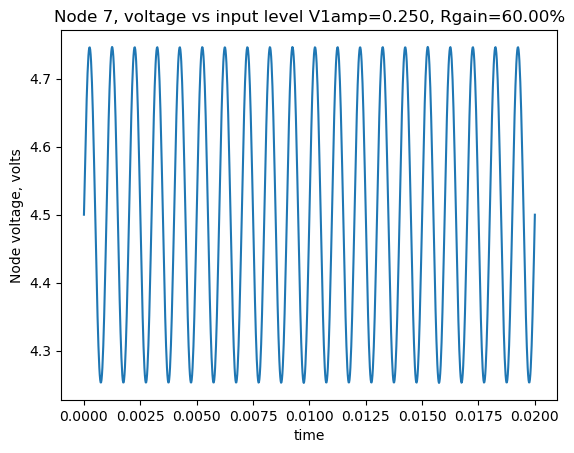

In [25]:
#| label: fig-Node_7_voltage
#| echo: true
#| fig-cap: Node 7, voltage plot

i = 127

plt.plot(np.asarray(td_node_voltage_df.loc[i]['time'], dtype=float),
         np.asarray(td_node_voltage_df.loc[i]['V7'], dtype=float),
         '-')


plt.ylabel('Node voltage, volts')
plt.xlabel('time')
#plt.grid()
plt.title('Node 7, voltage vs input level V1amp={:.3f}, Rgain={:.2f}%'.format(td_node_voltage_df.loc[i]['V1amp'],td_node_voltage_df.loc[i]['Rgain']))

#plt.legend(loc="lower right")
#plt.legend(bbox_to_anchor=(1.1,1))
plt.show()

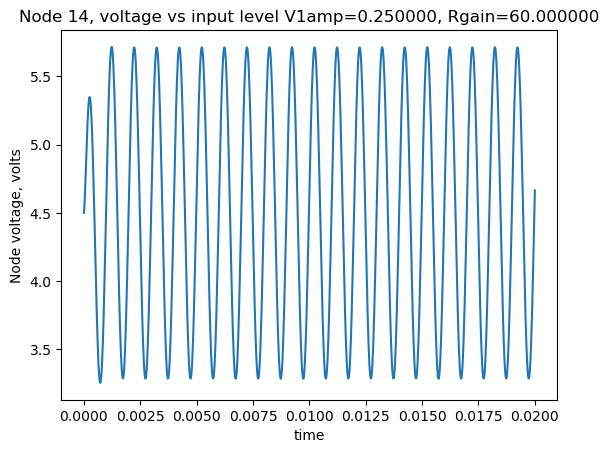

In [26]:
#| label: fig-Node_14_voltage
#| echo: true
#| fig-cap: Node 7, voltage plot

plt.plot(np.asarray(td_node_voltage_df.loc[i]['time'], dtype=float),
         np.asarray(td_node_voltage_df.loc[i]['V14'], dtype=float),
         '-')


plt.ylabel('Node voltage, volts')
plt.xlabel('time')
#plt.grid()
plt.title('Node 14, voltage vs input level V1amp={:f}, Rgain={:f}'.format(td_node_voltage_df.loc[i]['V1amp'],td_node_voltage_df.loc[i]['Rgain']))

#plt.legend(loc="lower right")
#plt.legend(bbox_to_anchor=(1.1,1))
plt.show()

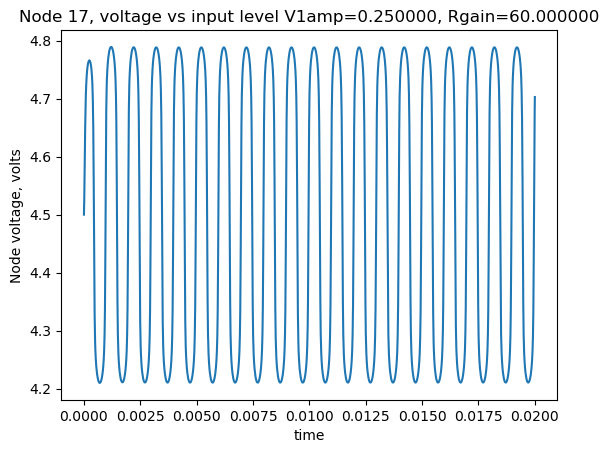

In [27]:
#| label: fig-Node_17_voltage
#| echo: true
#| fig-cap: Node 17, voltage plot

plt.plot(np.asarray(td_node_voltage_df.loc[i]['time'], dtype=float),
         np.asarray(td_node_voltage_df.loc[i]['V17'], dtype=float),
         '-')

plt.ylabel('Node voltage, volts')
plt.xlabel('time')
#plt.grid()
plt.title('Node 17, voltage vs input level V1amp={:f}, Rgain={:f}'.format(td_node_voltage_df.loc[i]['V1amp'],td_node_voltage_df.loc[i]['Rgain']))

#plt.legend(loc="lower right")
#plt.legend(bbox_to_anchor=(1.1,1))
plt.show()

## Plot time

In [28]:
t_data = np.asarray(td_node_voltage_df.loc[i]['time'], dtype=float)
y_data = np.asarray(td_node_voltage_df.loc[i]['V17'], dtype=float) - 4.5

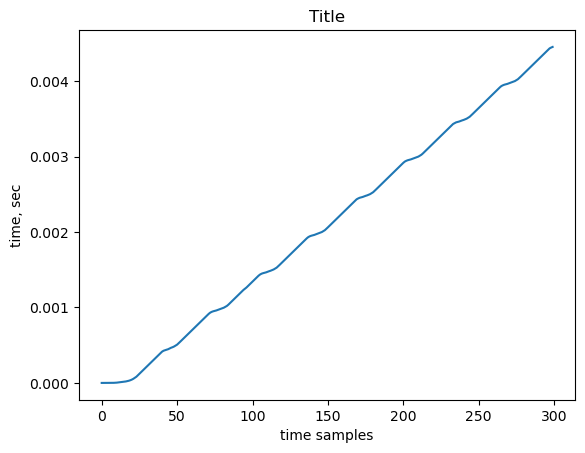

In [29]:
# plot the data
plt.plot(t_data[0:300])
plt.xlabel('time samples')
plt.ylabel('time, sec')
plt.title('Title')
plt.show()

Matplotlib will plot data with variable spacing if x values. But the FFT needs uniform sampling.

In [30]:
stop_time = 20e-3
xnew = np.linspace(0, stop_time, int(len(t_data))) #np.linspace(0, 10, num=1001)
ynew = np.interp(xnew, t_data, y_data)

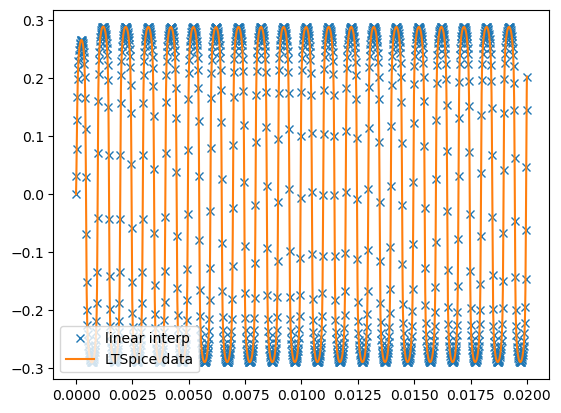

In [31]:
plt.plot(xnew, ynew, 'x', label='linear interp')

plt.plot(t_data, y_data, '-', label='LTSpice data')

plt.legend(loc='lower left')

plt.show()

### FFT calculation

- what are the units?
- converting to power or dBm

Use a window function

In [32]:
#w = tukey(n)
fft_window = blackman(len(xnew))
yw = ynew*fft_window

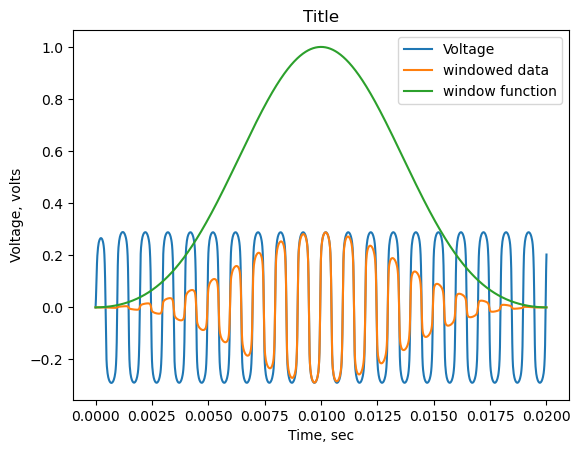

In [33]:
# plot the data
plt.plot(xnew,ynew)
plt.plot(xnew ,yw)
plt.plot(xnew,fft_window)
plt.xlabel('Time, sec')
plt.ylabel('Voltage, volts')
plt.legend(['Voltage', 'windowed data', 'window function'], loc='best')
plt.title('Title')
plt.show()

In [34]:
print('peak value: {:.3f} volts'.format(yw.max()))

peak value: 0.288 volts


The fftfreq() function returns a float array containing the frequency bin centers in cycles per unit of the sample spacing (with zero at the start). Since the sample spacing is in seconds, the frequency unit is cycles/second.

In [35]:
sample_freq = scipy.fft.fftfreq(len(ynew), 1./len(ynew))
fft_v17 = scipy.fft.fft(yw)

Plot the data on a semilog scale.

In [36]:
num_samples = len(ynew)
num_samples

In [37]:
sps = num_samples/stop_time
sps

In [38]:
nyquist_freq = sps/2
nyquist_freq

In [39]:
dt = stop_time/len(xnew)
dt

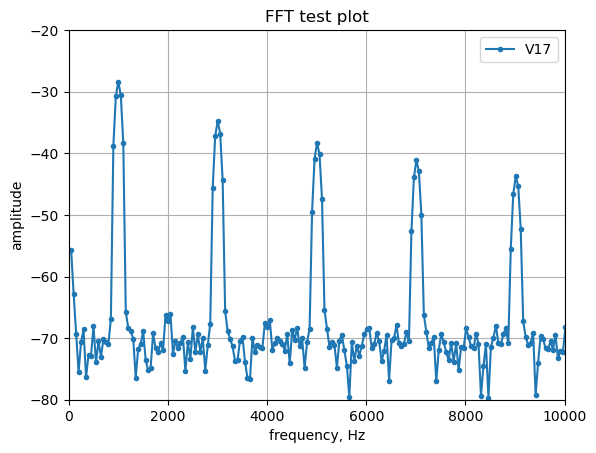

In [40]:
pidxs = np.where(sample_freq > 0)
freqs, amplitude_v17 = sample_freq[pidxs], np.abs(fft_v17[pidxs])
amplitude_v17 *= dt
#plt.semilogy(freqs,amplitude)
plt.plot(freqs*nyquist_freq/len(pidxs[0]),10*np.log10(amplitude_v17),'.-',label='V17')
plt.xlim(0,10000)
plt.ylim(-80,-20)
plt.ylabel('amplitude')
plt.xlabel('frequency, Hz')
plt.title('FFT test plot')
plt.legend(loc='best')
plt.grid()
plt.show()

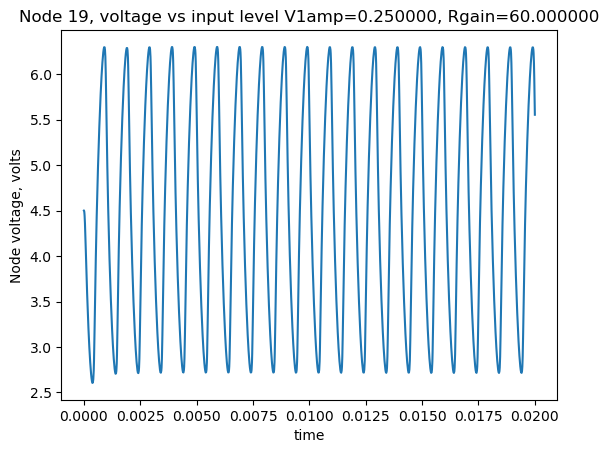

In [41]:
#| label: fig-Node_19_voltage
#| echo: true
#| fig-cap: Node 19, voltage plot

plt.plot(np.asarray(td_node_voltage_df.loc[i]['time'], dtype=float),
         np.asarray(td_node_voltage_df.loc[i]['V19'], dtype=float),
         '-')

plt.ylabel('Node voltage, volts')
plt.xlabel('time')
#plt.grid()
plt.title('Node 19, voltage vs input level V1amp={:f}, Rgain={:f}'.format(td_node_voltage_df.loc[i]['V1amp'],td_node_voltage_df.loc[i]['Rgain']))

#plt.legend(loc="lower right")
#plt.legend(bbox_to_anchor=(1.1,1))
plt.show()

In [42]:
t_data = np.asarray(td_node_voltage_df.loc[i]['time'], dtype=float)
y_data = np.asarray(td_node_voltage_df.loc[i]['V19'], dtype=float) - 4.5

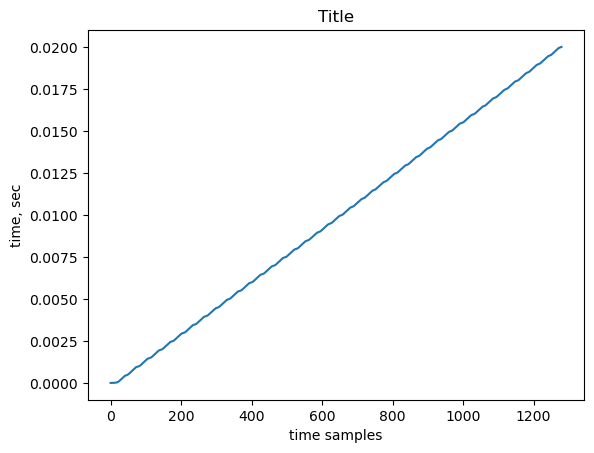

In [43]:
# plot the data
plt.plot(t_data)
plt.xlabel('time samples')
plt.ylabel('time, sec')
plt.title('Title')
plt.show()

Matplotlib will plot data with variable spacing if x values. But the FFT needs uniform sampling.

In [44]:
xnew = np.linspace(0, stop_time, int(len(t_data))) #np.linspace(0, 10, num=1001)
ynew = np.interp(xnew, t_data, y_data)

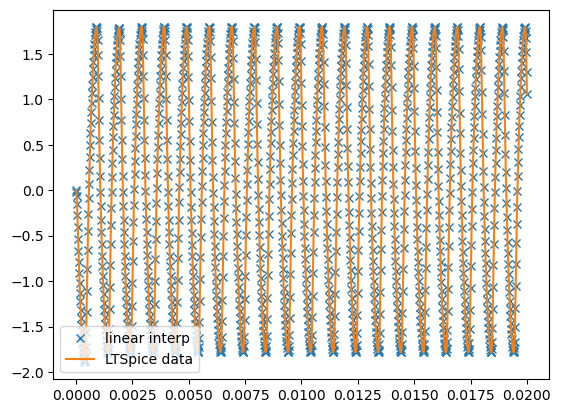

In [45]:
plt.plot(xnew, ynew, 'x', label='linear interp')

plt.plot(t_data, y_data, '-', label='LTSpice data')

plt.legend(loc='lower left')

plt.show()

### FFT calculation

- what are the units?
- converting to power or dBm

Use a window function

In [46]:
#w = tukey(n)
fft_window = blackman(len(xnew))
yw = ynew*fft_window

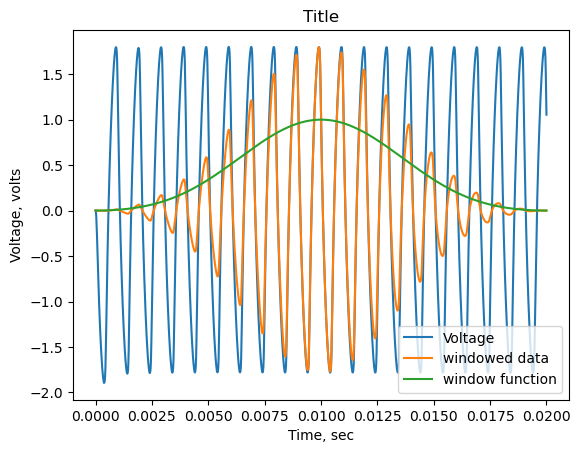

In [47]:
# plot the data
plt.plot(xnew,ynew)
plt.plot(xnew ,yw)
plt.plot(xnew,fft_window)
plt.xlabel('Time, sec')
plt.ylabel('Voltage, volts')
plt.legend(['Voltage', 'windowed data', 'window function'], loc='best')
plt.title('Title')
plt.show()

In [48]:
print('peak value: {:.3f} volts'.format(yw.max()))

peak value: 1.796 volts


The fftfreq() function returns a float array containing the frequency bin centers in cycles per unit of the sample spacing (with zero at the start). Since the sample spacing is in seconds, the frequency unit is cycles/second.

In [49]:
sample_freq = scipy.fft.fftfreq(len(ynew), 1./len(ynew))
fft_v19 = scipy.fft.fft(yw)

Plot the data on a semilog scale.

In [50]:
num_samples = len(ynew)
num_samples

In [51]:
#stop_time = 5e-3
sps = num_samples/stop_time
sps

In [52]:
nyquist_freq = sps/2
nyquist_freq

In [53]:
dt = stop_time/len(xnew)
dt

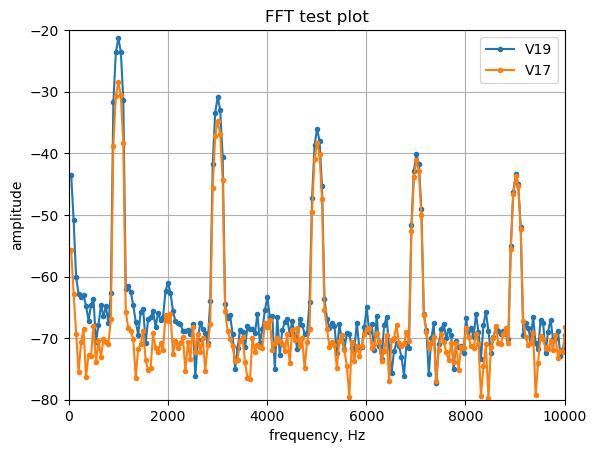

In [54]:
pidxs = np.where(sample_freq > 0)
freqs, amplitude_v19 = sample_freq[pidxs], np.abs(fft_v19[pidxs])
amplitude_v19 *= dt
#plt.semilogy(freqs,amplitude)
plt.plot(freqs*nyquist_freq/len(pidxs[0]),10*np.log10(amplitude_v19),'.-',label='V19')

plt.plot(freqs*nyquist_freq/len(pidxs[0]),10*np.log10(amplitude_v17),'.-',label='V17')

plt.xlim(0,10000)
plt.ylim(-80,-20)
plt.ylabel('amplitude')
plt.xlabel('frequency, Hz')
plt.title('FFT test plot')
plt.legend(loc='best')
plt.grid()
plt.show()

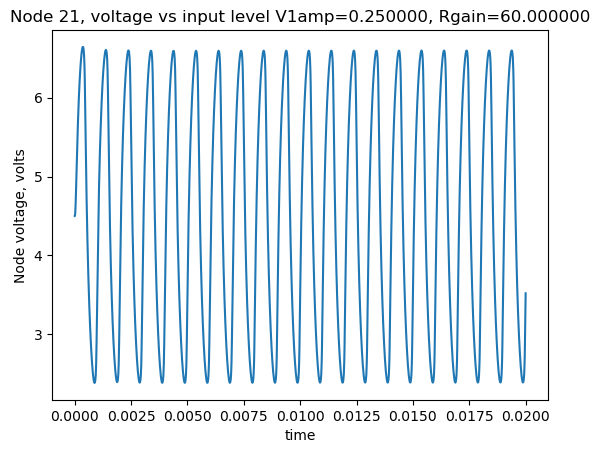

In [55]:
#| label: fig-Node_21_voltage
#| echo: true
#| fig-cap: Node 21, voltage plot

plt.plot(np.asarray(td_node_voltage_df.loc[i]['time'], dtype=float),
         np.asarray(td_node_voltage_df.loc[i]['V21'], dtype=float),
         '-')


plt.ylabel('Node voltage, volts')
plt.xlabel('time')
#plt.grid()
plt.title('Node 21, voltage vs input level V1amp={:f}, Rgain={:f}'.format(td_node_voltage_df.loc[i]['V1amp'],td_node_voltage_df.loc[i]['Rgain']))

#plt.legend(loc="lower right")
#plt.legend(bbox_to_anchor=(1.1,1))
plt.show()

In [56]:
t_data = np.asarray(td_node_voltage_df.loc[i]['time'], dtype=float)
y_data = np.asarray(td_node_voltage_df.loc[i]['V21'], dtype=float) - 4.5

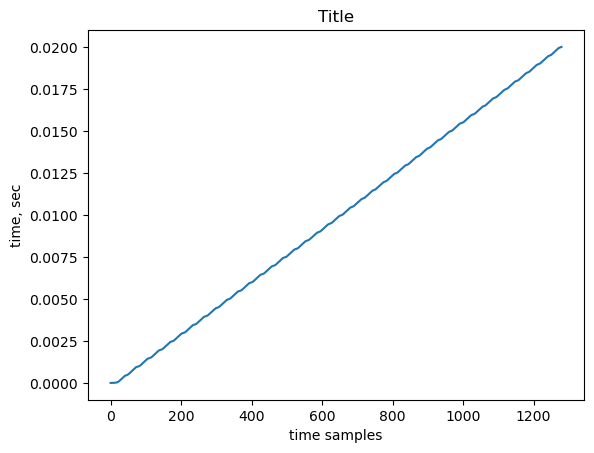

In [57]:
# plot the data
plt.plot(t_data)
plt.xlabel('time samples')
plt.ylabel('time, sec')
plt.title('Title')
plt.show()

Matplotlib will plot data with variable spacing if x values. But the FFT needs uniform sampling.

In [58]:
xnew = np.linspace(0, stop_time, int(len(t_data))) #np.linspace(0, 10, num=1001)
ynew = np.interp(xnew, t_data, y_data)

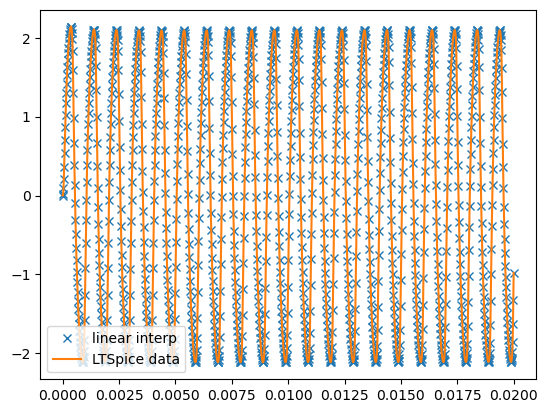

In [59]:
plt.plot(xnew, ynew, 'x', label='linear interp')

plt.plot(t_data, y_data, '-', label='LTSpice data')

plt.legend(loc='lower left')

plt.show()

### FFT calculation

- what are the units?
- converting to power or dBm

Use a window function

In [60]:
#w = tukey(n)
fft_window = blackman(len(xnew))
yw = ynew*fft_window

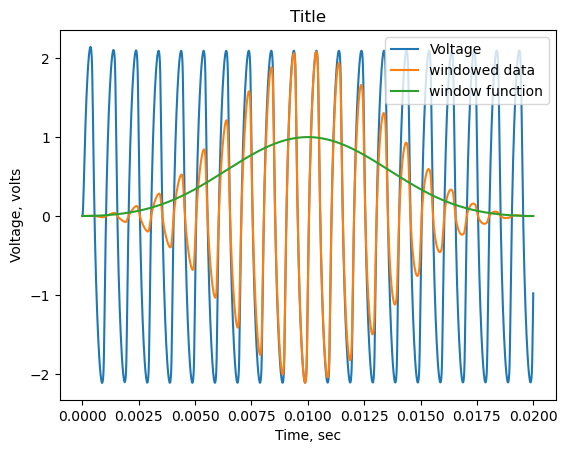

In [61]:
# plot the data
plt.plot(xnew,ynew)
plt.plot(xnew ,yw)
plt.plot(xnew,fft_window)
plt.xlabel('Time, sec')
plt.ylabel('Voltage, volts')
plt.legend(['Voltage', 'windowed data', 'window function'], loc='best')
plt.title('Title')
plt.show()

In [62]:
print('peak value: {:.3f} volts'.format(yw.max()))

peak value: 2.082 volts


The fftfreq() function returns a float array containing the frequency bin centers in cycles per unit of the sample spacing (with zero at the start). Since the sample spacing is in seconds, the frequency unit is cycles/second.

In [63]:
sample_freq = scipy.fft.fftfreq(len(ynew), 1./len(ynew))
fft_v21 = scipy.fft.fft(yw)

Plot the data on a semilog scale.

In [64]:
num_samples = len(ynew)
num_samples

In [65]:
#stop_time = 5e-3
sps = num_samples/stop_time
sps

In [66]:
nyquist_freq = sps/2
nyquist_freq

In [67]:
dt = stop_time/len(xnew)
dt

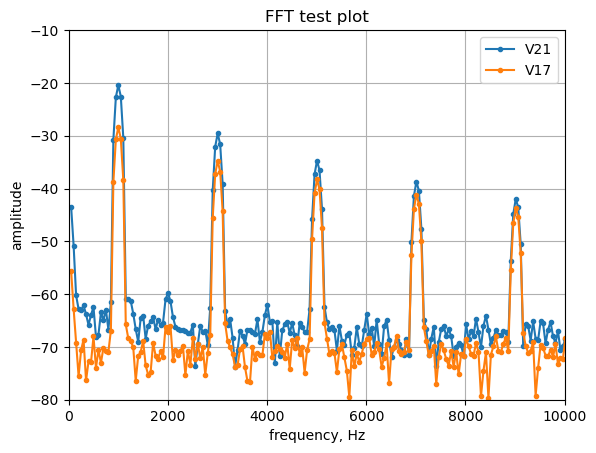

In [68]:
pidxs = np.where(sample_freq > 0)
freqs, amplitude_v21 = sample_freq[pidxs], np.abs(fft_v21[pidxs])
amplitude_v21 *= dt
#plt.semilogy(freqs,amplitude)
plt.plot(freqs*nyquist_freq/len(pidxs[0]),10*np.log10(amplitude_v21),'.-',label='V21')

plt.plot(freqs*nyquist_freq/len(pidxs[0]),10*np.log10(amplitude_v17),'.-',label='V17')

plt.xlim(0,10000)
plt.ylim(-80,-10)
plt.ylabel('amplitude')
plt.xlabel('frequency, Hz')
plt.title('FFT test plot')
plt.legend(loc='best')
plt.grid()
plt.show()

## Actual signals

wave files from [Sample Focus](https://samplefocus.com/)

clean-electric-guitar-harmonic-reality.wav

clean-electric-guitar-comfy-afternoon.wav

What rights do I have for samples I download from this service?

You may remix, transform, and build upon the material for any purpose, even commercially. All sounds on Sample Focus are licensed under our [Standard License](https://samplefocus.com/license).

This means that all sounds are royalty free and no attribution is required!


cut out a section of the audio and plot signals and FFT


.wave "klon_out.wav" 16 44.1k V(2)

wavefile = clean-electric-guitar-comfy-afternoon.wav capied to value of V1

.WAVE -- Write Selected Nodes to a .Wav File.

 

LTspice can write .wav audio files.  These files can then be listened to or be used as the input of another simulation.

 

Syntax:  .wave <filename.wav> <Nbits>  <SampleRate> V(out) [V(out2) ...]

 

example: .wave C:\output.wav 16 44.1K V(left) V(right)

 

<filename.wav> is either a complete absolute path for the .wav file you wish to create or a relative path computed from the directory containing the simulation schematic or netlist.  Double quotes may be used to specify a path containing spaces.  <Nbits> is the number of sampling bits.  The valid range is from 1 to 32 bits.
<SampleRate> is the number of samples to write per simulated second.  The valid range is 1 to 4294967295 samples be second. The remainder of the syntax lists the nodes that you wish to save. Each node will be an independent channel in the .wav file.  The number of channels may be as few as one or as many as 65535.  It is possible to write a device current, e.g., Ib(Q1) as well as node voltage.  The .wav analog to digital converter has a full scale range of -1 to +1 Volt or Amp.

 

Note that it is possible to write .wav files that cannot be played on your PC sound system because of the number of channels, sample rate or number of bits due to limitations of your PC's codec.  But these .wav files may still be used in LTspice as input for another simulation. See the sections LTspice=>Circuit Elements=>V. Voltage Source and I. Current source for information on playing a .wav file into an LTspice simulation. If you want to play the .wav file on your PC sound card, keep in mind that the more popularly supported .wav file formats have 1 or 2 channels; 8 or 16 bits/channel; and a sample rate of 11025, 22050, or 44100 Hz.
    
Wave file as an input    
wavefile=output.wav chan=0    
    
    
   

In [69]:
LTSpice_wavefile_df = pd.read_csv('wavefile_Vin.csv',delimiter='\t')

In [70]:
LTSpice_wavefile_df.head(10)

,time,V(1),V(2),V(14)-4.5,V(16)
0,0.000000,4.499921e-24,6.839725e-13,0.000218,7.566022e-13
1,0.000386,-3.242693e-07,-5.593652e-08,0.000217,-2.294244e-07
2,0.000392,-8.991888e-06,-2.135811e-06,0.000205,-1.153911e-05
3,0.000399,-1.766024e-05,-6.099190e-06,0.000190,-2.611201e-05
4,0.000405,-2.632934e-05,-1.194607e-05,0.000171,-4.394813e-05
5,0.000412,-3.499917e-05,-1.967646e-05,0.000149,-6.504747e-05
6,0.000418,-4.366974e-05,-2.929036e-05,0.000123,-8.941003e-05
7,0.000424,-5.234105e-05,-4.078776e-05,0.000094,-1.170358e-04
8,0.000431,-6.101310e-05,-5.416866e-05,0.000061,-1.479248e-04
9,0.000437,-7.730443e-05,-7.190395e-05,0.000018,-1.888111e-04


In [71]:
LTSpice_wavefile_df.tail(10)

,time,V(1),V(2),V(14)-4.5,V(16)
1131607,6.420184,-0.000519,-0.000124,0.000125,-0.000358
1131608,6.426532,-0.000519,-0.000027,0.000180,-0.000304
1131609,6.432880,-0.000519,0.000010,0.000213,-0.000276
1131610,6.439227,-0.000519,0.000016,0.000233,-0.000261
1131611,6.445575,-0.000519,0.000007,0.000244,-0.000254
1131612,6.464618,-0.000519,-0.000035,0.000255,-0.000244
1131613,6.477313,-0.000519,-0.000055,0.000253,-0.000238
1131614,6.490009,-0.000519,-0.000065,0.000250,-0.000229
1131615,6.496356,-0.000519,-0.000068,0.000248,-0.000224
1131616,6.500000,-0.000519,-0.000069,0.000247,-0.000221


In [72]:
t_data = np.asarray(LTSpice_wavefile_df['time'], dtype=float)

In [73]:
v1_data = np.asarray(LTSpice_wavefile_df['V(1)'], dtype=float)

In [74]:
v2_data = np.asarray(LTSpice_wavefile_df['V(2)'], dtype=float)

In [75]:
v14_data = np.asarray(LTSpice_wavefile_df['V(14)-4.5'], dtype=float)

In [76]:
v16_data = np.asarray(LTSpice_wavefile_df['V(16)'], dtype=float)

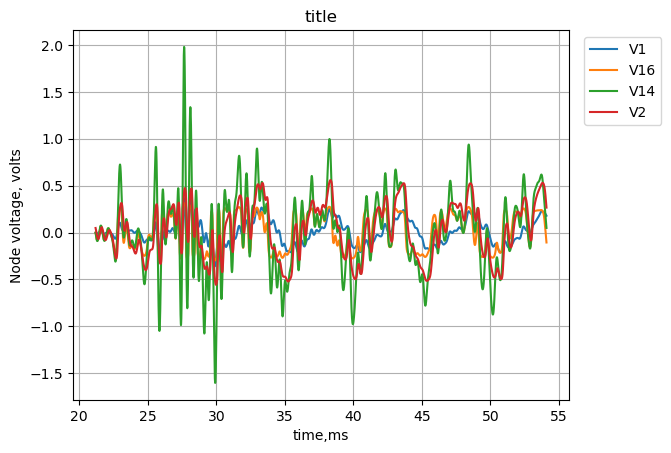

In [77]:
start_index = 3500
stop_index = 10000
plt.plot(t_data[start_index:stop_index]*1000,v1_data[start_index:stop_index],'-',label='V1')
plt.plot(t_data[start_index:stop_index]*1000,v16_data[start_index:stop_index],'-',label='V16')
plt.plot(t_data[start_index:stop_index]*1000,v14_data[start_index:stop_index],'-',label='V14')
plt.plot(t_data[start_index:stop_index]*1000,v2_data[start_index:stop_index],'-',label='V2')

plt.ylabel('Node voltage, volts')
plt.xlabel('time,ms')
plt.grid()
plt.title('title')

#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.2,1))
plt.show()

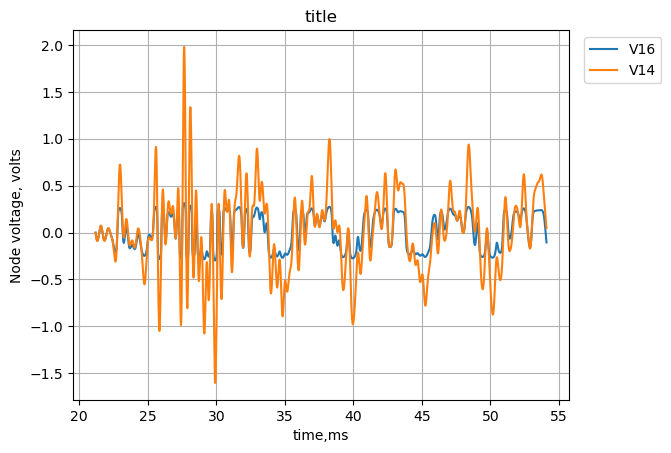

In [78]:
start_index = 3500
stop_index = 10000
#plt.plot(t_data[start_index:stop_index]*1000,v1_data[start_index:stop_index],'-',label='V1')
plt.plot(t_data[start_index:stop_index]*1000,v16_data[start_index:stop_index],'-',label='V16')
plt.plot(t_data[start_index:stop_index]*1000,v14_data[start_index:stop_index],'-',label='V14')
#plt.plot(t_data[start_index:stop_index]*1000,v2_data[start_index:stop_index],'-',label='V2')

plt.ylabel('Node voltage, volts')
plt.xlabel('time,ms')
plt.grid()
plt.title('title')

#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.2,1))
plt.show()

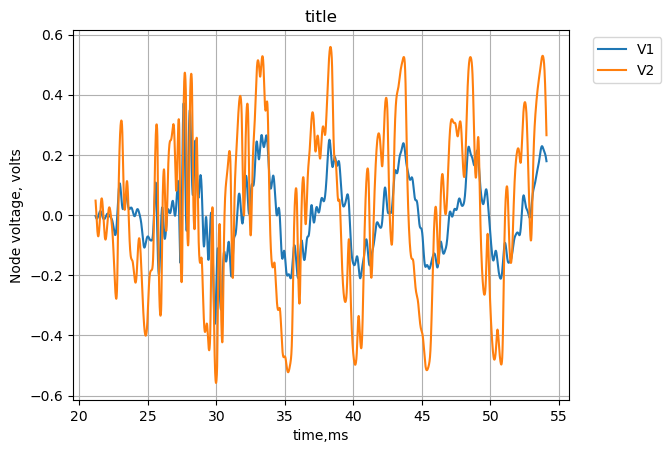

In [79]:
start_index = 3500
stop_index = 10000
plt.plot(t_data[start_index:stop_index]*1000,v1_data[start_index:stop_index],'-',label='V1')
#plt.plot(t_data[start_index:stop_index]*1000,v16_data[start_index:stop_index],'-',label='V16')
#plt.plot(t_data[start_index:stop_index]*1000,v14_data[start_index:stop_index],'-',label='V14')
plt.plot(t_data[start_index:stop_index]*1000,v2_data[start_index:stop_index],'-',label='V2')

plt.ylabel('Node voltage, volts')
plt.xlabel('time,ms')
plt.grid()
plt.title('title')

#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.2,1))
plt.show()

## Looking at the FFT of output and input wave files

In [80]:
from scipy.io import wavfile
import scipy.io

In [81]:
samplerate_output, wave_output = wavfile.read('klon_out.wav')
length_out = wave_output.shape[0] / samplerate_output
print(f"length = {length_out}s")

length = 6.500022675736961s


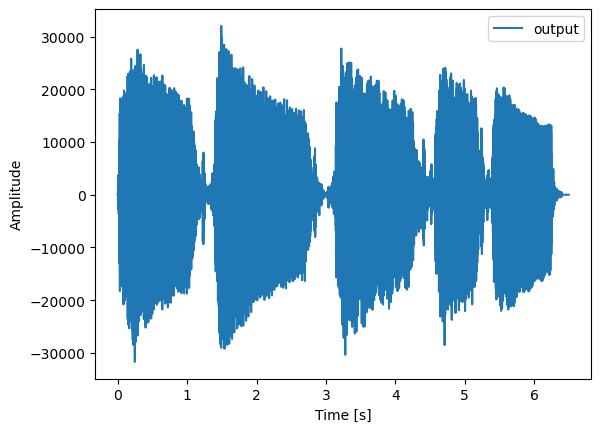

In [82]:
time = np.linspace(0, length_out, len(wave_output))
plt.plot(time, wave_output, label="output")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

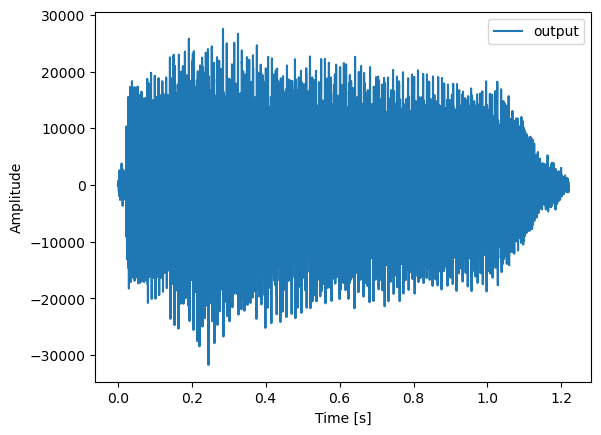

In [83]:
time = np.linspace(0, length_out, len(wave_output))
plt.plot(time[0:53802], wave_output[0:53802], label="output")
#plt.xlim((0,1.22))
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

### FFT calculation
with window.

In [84]:
#w = tukey(n)
fft_window = blackman(len(time[0:53802]))
yw = wave_output[0:53802]*fft_window

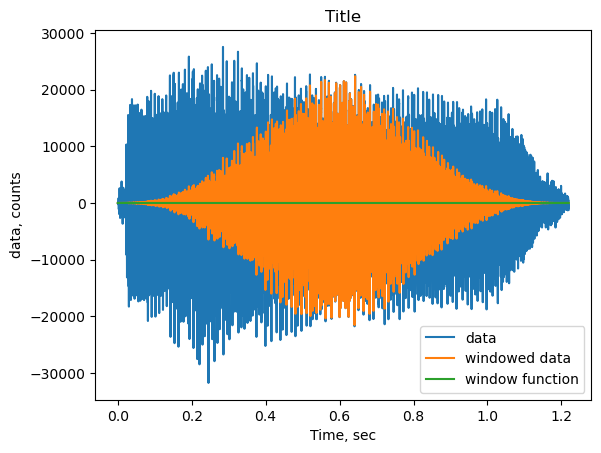

In [85]:
# plot the data
plt.plot(time[0:53802],wave_output[0:53802])
plt.plot(time[0:53802] ,yw)
plt.plot(time[0:53802],fft_window)
plt.xlabel('Time, sec')
plt.ylabel('data, counts')
plt.legend(['data', 'windowed data', 'window function'], loc='best')
plt.title('Title')
plt.show()

In [86]:
print('peak value: {:.3f} counts'.format(yw.max()))

peak value: 22350.506 counts


The fftfreq() function returns a float array containing the frequency bin centers in cycles per unit of the sample spacing (with zero at the start). Since the sample spacing is in seconds, the frequency unit is cycles/second.

In [87]:
sample_freq = scipy.fft.fftfreq(len(wave_output[0:53802]), 1./len(wave_output[0:53802]))
fft_output = scipy.fft.fft(yw)

Plot the data on a semilog scale.

In [88]:
num_samples = len(wave_output[0:53802])
num_samples

In [89]:
stop_time = time[53802]
sps = num_samples/stop_time
sps

In [90]:
nyquist_freq = sps/2
nyquist_freq

In [91]:
dt = stop_time/len(time[0:53802])
dt

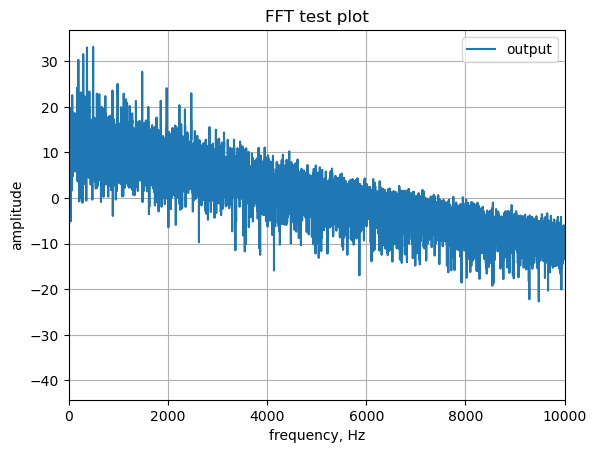

In [92]:
pidxs = np.where(sample_freq > 0)
freqs, amplitude_output = sample_freq[pidxs], np.abs(fft_output[pidxs])
amplitude_output *= dt
#plt.semilogy(freqs,amplitude)
plt.plot(freqs*nyquist_freq/len(pidxs[0]),10*np.log10(amplitude_output),'-',label='output')

plt.xlim(0,10000)
#plt.ylim(-80,-10)
plt.ylabel('amplitude')
plt.xlabel('frequency, Hz')
plt.title('FFT test plot')
plt.legend(loc='best')
plt.grid()
plt.show()

In [93]:
samplerate_input, wave_input = wavfile.read('clean-electric-guitar-harmonic-reality.wav')
length_in = wave_input.shape[0] / samplerate_input
print(f"length = {length_in}s")

length = 6.4s


In [94]:
samplerate_input

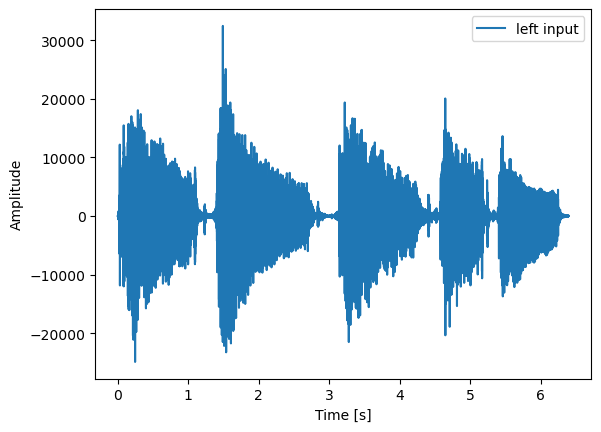

In [95]:
time = np.linspace(0, length_in, len(wave_input))
plt.plot(time, wave_input[:, 0], label="left input")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

### FFT calculation w/o window
comment out some code to not used the window.

In [96]:
#w = tukey(n)
fft_window = blackman(len(time[0:53802]))
yw = wave_output[0:53802] #*fft_window

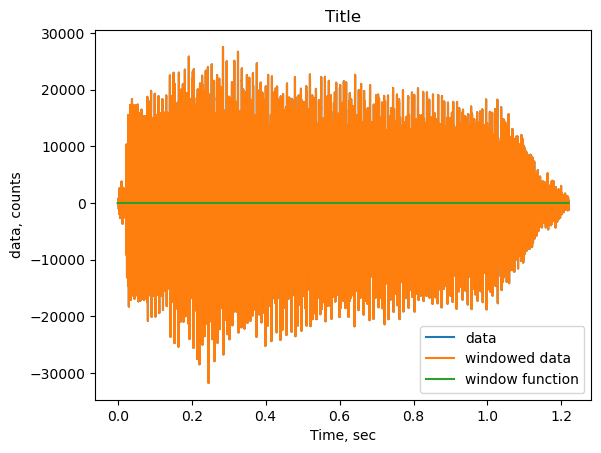

In [97]:
# plot the data
plt.plot(time[0:53802],wave_output[0:53802])
plt.plot(time[0:53802] ,yw)
plt.plot(time[0:53802],fft_window)
plt.xlabel('Time, sec')
plt.ylabel('data, counts')
plt.legend(['data', 'windowed data', 'window function'], loc='best')
plt.title('Title')
plt.show()

In [98]:
print('peak value: {:.3f} counts'.format(yw.max()))

peak value: 27514.000 counts


The fftfreq() function returns a float array containing the frequency bin centers in cycles per unit of the sample spacing (with zero at the start). Since the sample spacing is in seconds, the frequency unit is cycles/second.

In [99]:
sample_freq = scipy.fft.fftfreq(len(wave_output[0:53802]), 1./len(wave_output[0:53802]))
fft_output = scipy.fft.fft(yw)

Plot the data on a semilog scale.

In [100]:
num_samples = len(wave_output[0:53802])
num_samples

In [101]:
stop_time = time[53802]
sps = num_samples/stop_time
sps

In [102]:
nyquist_freq = sps/2
nyquist_freq

In [103]:
dt = stop_time/len(time[0:53802])
dt

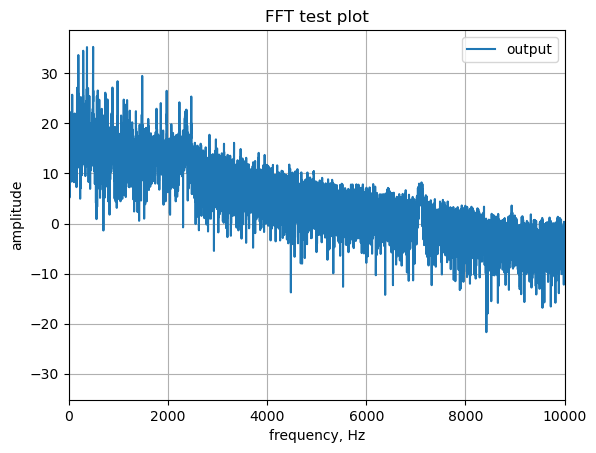

In [104]:
pidxs = np.where(sample_freq > 0)
freqs, amplitude_output = sample_freq[pidxs], np.abs(fft_output[pidxs])
amplitude_output *= dt
#plt.semilogy(freqs,amplitude)
plt.plot(freqs*nyquist_freq/len(pidxs[0]),10*np.log10(amplitude_output),'-',label='output')

plt.xlim(0,10000)
#plt.ylim(-80,-10)
plt.ylabel('amplitude')
plt.xlabel('frequency, Hz')
plt.title('FFT test plot')
plt.legend(loc='best')
plt.grid()
plt.show()

Difference is a little bump at 7kHz, 

### FFT calculation


In [105]:
#w = tukey(n)
fft_window = blackman(len(time[0:53802]))
yw = wave_input[0:53802, 0]*fft_window

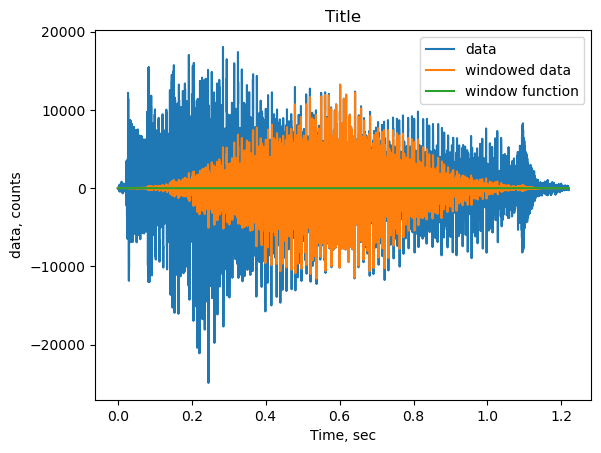

In [106]:
# plot the data
plt.plot(time[0:53802],wave_input[0:53802, 0])
plt.plot(time[0:53802] ,yw)
plt.plot(time[0:53802],fft_window)
plt.xlabel('Time, sec')
plt.ylabel('data, counts')
plt.legend(['data', 'windowed data', 'window function'], loc='best')
plt.title('Title')
plt.show()

In [107]:
print('peak value: {:.3f} counts'.format(yw.max()))

peak value: 13225.400 counts


The fftfreq() function returns a float array containing the frequency bin centers in cycles per unit of the sample spacing (with zero at the start). Since the sample spacing is in seconds, the frequency unit is cycles/second.

In [108]:
sample_freq = scipy.fft.fftfreq(len(wave_input[0:53802, 0]), 1./len(wave_input[0:53802, 0]))
fft_input = scipy.fft.fft(yw)

Plot the data on a semilog scale.

In [109]:
num_samples = len(wave_input[0:53802, 0])
num_samples

In [110]:
stop_time = time[53802]
sps = num_samples/stop_time
sps

In [111]:
nyquist_freq = sps/2
nyquist_freq

In [112]:
dt = stop_time/len(time[0:53802])
dt

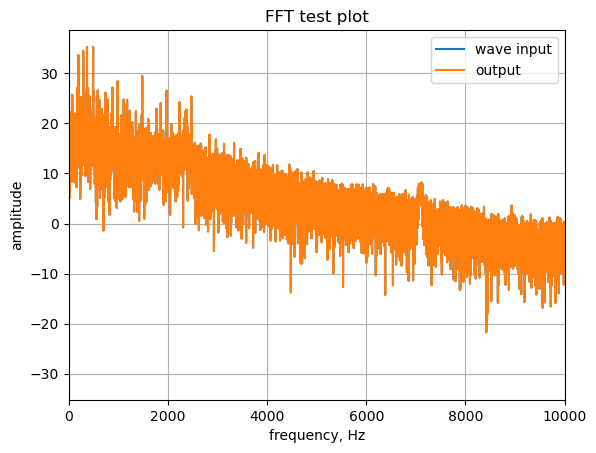

In [113]:
pidxs = np.where(sample_freq > 0)
freqs, amplitude_input = sample_freq[pidxs], np.abs(fft_input[pidxs])
amplitude_input *= dt
#plt.semilogy(freqs,amplitude)
plt.plot(freqs*nyquist_freq/len(pidxs[0]),10*np.log10(amplitude_output),'-',label='wave input')
plt.plot(freqs*nyquist_freq/len(pidxs[0]),10*np.log10(amplitude_output),'-',label='output')
plt.xlim(0,10000)
#plt.ylim(-80,-10)
plt.ylabel('amplitude')
plt.xlabel('frequency, Hz')
plt.title('FFT test plot')
plt.legend(loc='best')
plt.grid()
plt.show()

### FFT calculation w/o window


In [114]:
#w = tukey(n)
fft_window = blackman(len(time[0:53802]))
yw = wave_input[0:53802, 0] #*fft_window

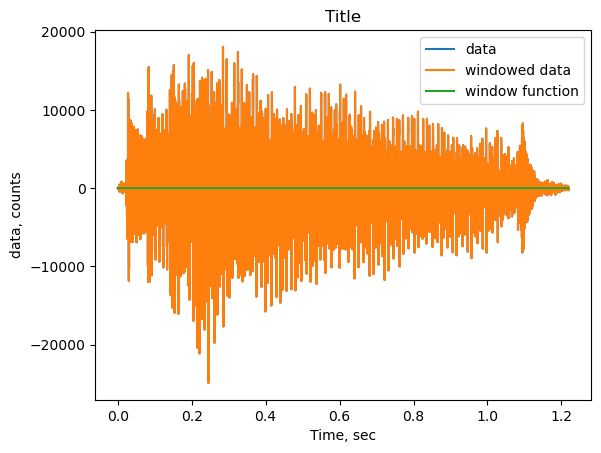

In [115]:
# plot the data
plt.plot(time[0:53802],wave_input[0:53802, 0])
plt.plot(time[0:53802] ,yw)
plt.plot(time[0:53802],fft_window)
plt.xlabel('Time, sec')
plt.ylabel('data, counts')
plt.legend(['data', 'windowed data', 'window function'], loc='best')
plt.title('Title')
plt.show()

In [116]:
print('peak value: {:.3f} counts'.format(yw.max()))

peak value: 18059.000 counts


The fftfreq() function returns a float array containing the frequency bin centers in cycles per unit of the sample spacing (with zero at the start). Since the sample spacing is in seconds, the frequency unit is cycles/second.

In [117]:
sample_freq = scipy.fft.fftfreq(len(wave_input[0:53802, 0]), 1./len(wave_input[0:53802, 0]))
fft_input = scipy.fft.fft(yw)

Plot the data on a semilog scale.

In [118]:
num_samples = len(wave_input[0:53802, 0])
num_samples

In [119]:
stop_time = time[53802]
sps = num_samples/stop_time
sps

In [120]:
nyquist_freq = sps/2
nyquist_freq

In [121]:
dt = stop_time/len(time[0:53802])
dt

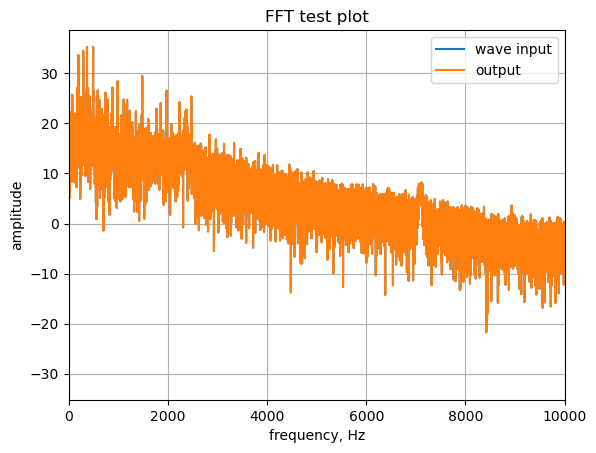

In [122]:
pidxs = np.where(sample_freq > 0)
freqs, amplitude_input = sample_freq[pidxs], np.abs(fft_input[pidxs])
amplitude_input *= dt
#plt.semilogy(freqs,amplitude)
plt.plot(freqs*nyquist_freq/len(pidxs[0]),10*np.log10(amplitude_output),'-',label='wave input')
plt.plot(freqs*nyquist_freq/len(pidxs[0]),10*np.log10(amplitude_output),'-',label='output')
plt.xlim(0,10000)
#plt.xlim(0,2000)
#plt.ylim(-80,-10)
plt.ylabel('amplitude')
plt.xlabel('frequency, Hz')
plt.title('FFT test plot')
plt.legend(loc='best')
plt.grid()
plt.show()